# Comparing QAOA warm-start methods

In [1]:
import sys
sys.path.insert(0, './../')
from quantum_solvers import *
from helper_functions import *
from save_results import *
from qiskit.providers.aer import AerSimulator
from seaborn import *
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
blue = color_palette('deep')[0]
backend = AerSimulator(method='statevector', device='GPU', precision='single')
# from qiskit_braket_provider import BraketLocalBackend
# backend = BraketLocalBackend()

## Single graph example

In [2]:
n_qubits = 20
n_layers = 4
shots = 512
info = {'n_qubits':n_qubits, 'n_layers':n_layers, 'shots':shots}
max_circ_evals = 250

graph = random_graph(n_qubits, list(range(1, 11)))
exact_obj = akmaxsat(graph)[1]
print('True max-cut obj:', exact_obj)

standard_qaoa = QAOASolver(n_layers=n_layers, warm_start_method=None, epsilon=None, backend=backend, shots=shots, max_circ_evals=max_circ_evals)
standard_res = standard_qaoa.solve(graph)
print('\nStandard QAOA\n', standard_res)

gw_rounded_qaoa = QAOASolver(n_layers=n_layers, warm_start_method='GW Rounded', epsilon=.25, backend=backend, shots=shots, max_circ_evals=max_circ_evals)
gw_rounded_res = gw_rounded_qaoa.solve(graph)
print('\nGW-WS-QAOA\n', gw_rounded_res)

bmz_relaxed = BMZ(graph)

bmz_rounded_qaoa = QAOASolver(n_layers=n_layers, warm_start_method='BMZ Rounded', epsilon=.25, backend=backend, shots=shots, max_circ_evals=max_circ_evals)
bmz_rounded_res = bmz_rounded_qaoa.solve(graph, relaxed_solution=bmz_relaxed)
print('\nBMZ-Rounded-WS-QAOA\n', bmz_rounded_res)

bmz_qaoa = QAOASolver(n_layers=n_layers, warm_start_method='BMZ', epsilon=.2, backend=backend, shots=shots, max_circ_evals=max_circ_evals)
bmz_res = bmz_qaoa.solve(graph, relaxed_solution=bmz_relaxed)
print('\nBMZ-WS-QAOA\n', bmz_res)

True max-cut obj: -643.0

Standard QAOA
      bitstring: 01111110010010010100
           obj: -627.0
   expectation: -568.0703125
unique_samples: 512
     optimizer: COBYLA
n_circ_evals: : 96
opt_terminated: True

GW-WS-QAOA
      bitstring: 00111011011100110000
           obj: -637.0
   relaxed_obj: -620.0
 n_regularized: 20
   expectation: -611.552734375
unique_samples: 111
     optimizer: COBYLA
n_circ_evals: : 100
opt_terminated: True

BMZ-Rounded-WS-QAOA
      bitstring: 10110011011110010000
           obj: -638.0
   relaxed_obj: -635.0
 n_regularized: 20
   expectation: -633.41015625
unique_samples: 22
     optimizer: COBYLA
n_circ_evals: : 104
opt_terminated: True

BMZ-WS-QAOA
      bitstring: 00111011011110010000
           obj: -643.0
   relaxed_obj: -635.0
 n_regularized: 4
   expectation: -609.759765625
unique_samples: 301
     optimizer: COBYLA
n_circ_evals: : 94
opt_terminated: True


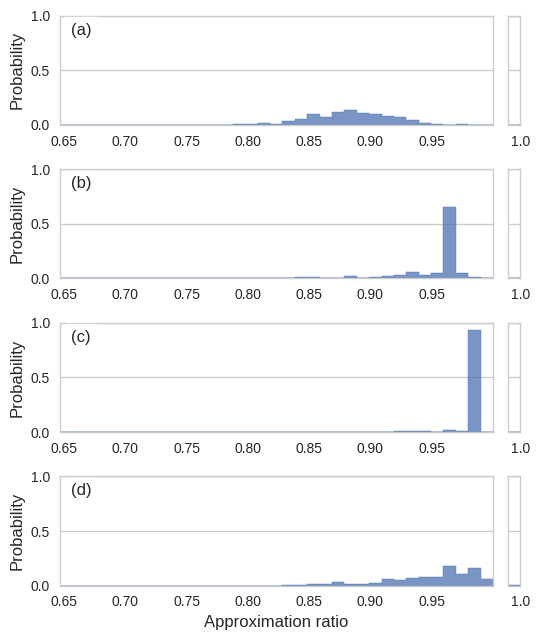

In [3]:
standard_bars = get_ratio_counts(standard_res.counts, graph)
gw_rounded_bars = get_ratio_counts(gw_rounded_res.counts, graph)
bmz_rounded_bars = get_ratio_counts(bmz_rounded_res.counts, graph)
bmz_bars = get_ratio_counts(bmz_res.counts, graph)

n_bins = 100
width = 1/n_bins

ymax = 0
xmin = 1
for dictionary in [standard_bars, gw_rounded_bars, bmz_rounded_bars, bmz_bars]:
    temp_max = max([dictionary[key] for key in dictionary.keys()])/shots
    sorted = np.sort([key for key in dictionary.keys()])
    counter = 0 
    temp_min = 0
    while temp_min == 0:
        temp_min = sorted[counter]
        counter += 1
    if temp_max > ymax:
        ymax = temp_max
    if temp_min < xmin:
        xmin = temp_min
ymax = min([1, 2*ymax])
xmin -= width

width_ratio = width/(1 - xmin)
fig, axes = plt.subplots(4, 2, figsize=(5.5, 6.5), width_ratios=[1 - width_ratio, width_ratio], sharey=True)
axes = axes.ravel()

standard_dense = []
standard_perfect = []
for key in standard_bars.keys():
    if key == 1:
        standard_perfect += [key]*standard_bars[key]
        standard_dense += [0]*standard_bars[key]
    else:
        standard_dense += [key]*standard_bars[key]
        standard_perfect += [0]*standard_bars[key]
histplot(standard_dense, ax=axes[0], stat='probability', bins=np.linspace(0, 1, n_bins), element='step')
axes[0].set_title('(a)', fontsize=12, x=.05, y=.75, backgroundcolor='white')
# axes[0].set_xlabel('Approximation ratio', fontsize=12)
axes[0].set_ylabel('Probability', fontsize=12)
axes[0].set_xlim(xmin, .9999)
axes[0].set_ylim(0, ymax)
axes[0].grid(False, axis='x')

histplot(standard_perfect, ax=axes[1], stat='probability', bins=np.linspace(0, 1, n_bins), element='step')
axes[1].set_xticks([1.0], ['1.0'])
axes[1].grid(False, axis='x')
axes[1].set_xlim(1 - width, 1)

gw_rounded_dense = []
gw_rounded_perfect = []
for key in gw_rounded_bars.keys():
    if key == 1:
        gw_rounded_perfect += [key]*gw_rounded_bars[key]
        gw_rounded_dense += [0]*gw_rounded_bars[key]
    else:
        gw_rounded_dense += [key]*gw_rounded_bars[key]
        gw_rounded_perfect += [0]*gw_rounded_bars[key]
histplot(gw_rounded_dense, ax=axes[2], stat='probability', bins=np.linspace(0, 1, n_bins), element='step')
axes[2].set_title('(b)', fontsize=12, x=.05, y=.75, backgroundcolor='white')
# axes[2].set_xlabel('Approximation ratio', fontsize=12)
axes[2].set_ylabel('Probability', fontsize=12)
axes[2].set_xlim(xmin, .9999)
axes[2].set_ylim(0, ymax)
axes[2].grid(False, axis='x')

histplot(gw_rounded_perfect, ax=axes[3], stat='probability', bins=np.linspace(0, 1, n_bins), element='step')
axes[3].set_xticks([1.0], ['1.0'])
axes[3].grid(False, axis='x')
axes[3].set_xlim(1 - width, 1)

bmz_rounded_dense = []
bmz_rounded_perfect = []
for key in bmz_rounded_bars.keys():
    if key == 1:
        bmz_rounded_perfect += [key]*bmz_rounded_bars[key]
        bmz_rounded_dense += [0]*bmz_rounded_bars[key]
    else:
        bmz_rounded_dense += [key]*bmz_rounded_bars[key]
        bmz_rounded_perfect += [0]*bmz_rounded_bars[key]
histplot(bmz_rounded_dense, ax=axes[4], stat='probability', bins=np.linspace(0, 1, n_bins), element='step')
axes[4].set_title('(c)', fontsize=12, x=.05, y=.75, backgroundcolor='white')
# axes[4].set_xlabel('Approximation ratio', fontsize=12)
axes[4].set_ylabel('Probability', fontsize=12)
axes[4].set_xlim(xmin, .9999)
axes[4].set_ylim(0, ymax)
axes[4].grid(False, axis='x')

histplot(bmz_rounded_perfect, ax=axes[5], stat='probability', bins=np.linspace(0, 1, n_bins), element='step')
axes[5].set_xticks([1.0], ['1.0'])
axes[5].grid(False, axis='x')
axes[5].set_xlim(1 - width, 1)

bmz_dense = []
bmz_perfect = []
for key in bmz_bars.keys():
    if key == 1:
        bmz_perfect += [key]*bmz_bars[key]
        bmz_dense += [0]*bmz_bars[key]
    else:
        bmz_dense += [key]*bmz_bars[key]
        bmz_perfect += [0]*bmz_bars[key]
histplot(bmz_dense, ax=axes[6], stat='probability', bins=np.linspace(0, 1, n_bins), element='step')
axes[6].set_title('(d)', fontsize=12, x=.05, y=.75, backgroundcolor='white')
axes[6].set_xlabel('Approximation ratio', fontsize=12)
axes[6].set_ylabel('Probability', fontsize=12)
axes[6].set_xlim(xmin, .9999)
axes[6].set_ylim(0, ymax)
axes[6].grid(False, axis='x')

histplot(bmz_perfect, ax=axes[7], stat='probability', bins=np.linspace(0, 1, n_bins), element='step')
axes[7].set_xticks([1.0], ['1.0'])
axes[7].grid(False, axis='x')
axes[7].set_xlim(1 - width, 1)

for i in range(8):
    axes[i].tick_params(axis='both', which='both', labelsize=10)


plt.tight_layout()
# save_plot('single_run')
# save_info(info, 'single_run')
plt.show()